<a href="https://colab.research.google.com/github/Satyaram-k/satyaram_INFO5731_Spring2020/blob/main/In_class_exercise/In_class_exercise_04.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **The fourth in-class-exercise (40 points in total, 03/29/2022)**

Question description: Please use the text corpus you collected in your last in-class-exercise for this exercise. Perform the following tasks:

## (1) (10 points) Generate K topics by using LDA, the number of topics K should be decided by the coherence score, then summarize what are the topics. You may refer the code here: 

https://www.machinelearningplus.com/nlp/topic-modeling-gensim-python/

In [1]:
# Write your code here
import nltk; nltk.download('stopwords')
import spacy.cli
spacy.cli.download("en_core_web_sm")

!pip install pyLDAvis

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_sm')
     |████████████████████████████████| 1.7 MB 5.0 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
    Preparing wheel metadata ... done
  Created wheel for pyLDAvis: filename=pyLDAvis-3.3.1-py2.py3-none-any.whl size=136898 sha256=2daf9d0f7fff3ce37db07be36e8ec1787ed84ff75f441d1340180db609e928b7
  Stored in directory: /root/.cache/pip/wheels/c9/21/f6/17bcf2667e8a68532ba2fbf6d5c72fdf4c7f7d9abfa4852d2f
Successfully built pyLDAvis


In [2]:
import re
import numpy as np
import pandas as pd
from pprint import pprint

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# spacy for lemmatization
import spacy

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim_models
import matplotlib.pyplot as plt
%matplotlib inline

# Enable logging for gensim - optional
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

/usr/local/lib/python3.7/dist-packages/past/types/oldstr.py:5: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import Iterable


In [3]:
# NLTK Stop words
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use'])

In [5]:
df = pd.read_csv('review_text.csv')

# Convert to list
data = df.Review.values.tolist()

# printing sample
pprint(data[:1])

['Purchased this product advertised as fully unlocked. Inserted my sim card '
 'and it did not work. Contacted my service provider and they checked my IMEI '
 'number and it reported that the phone was still locked by the original '
 "carrier. Phone came in good condition just couldn't use any service "
 'provider.']


In [6]:
# converting sentenses to words
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

data_words = list(sent_to_words(data))

print(data_words[:1])

[['purchased', 'this', 'product', 'advertised', 'as', 'fully', 'unlocked', 'inserted', 'my', 'sim', 'card', 'and', 'it', 'did', 'not', 'work', 'contacted', 'my', 'service', 'provider', 'and', 'they', 'checked', 'my', 'imei', 'number', 'and', 'it', 'reported', 'that', 'the', 'phone', 'was', 'still', 'locked', 'by', 'the', 'original', 'carrier', 'phone', 'came', 'in', 'good', 'condition', 'just', 'couldn', 'use', 'any', 'service', 'provider']]


In [7]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# See trigram example
print(trigram_mod[bigram_mod[data_words[0]]])

/usr/local/lib/python3.7/dist-packages/gensim/models/phrases.py:598: UserWarning: For a faster implementation, use the gensim.models.phrases.Phraser class
  warnings.warn("For a faster implementation, use the gensim.models.phrases.Phraser class")


['purchased', 'this', 'product', 'advertised', 'as', 'fully_unlocked', 'inserted', 'my', 'sim_card', 'and', 'it', 'did', 'not', 'work', 'contacted', 'my', 'service_provider', 'and', 'they', 'checked', 'my', 'imei', 'number', 'and', 'it', 'reported', 'that', 'the', 'phone', 'was', 'still', 'locked', 'by', 'the', 'original', 'carrier', 'phone', 'came', 'in', 'good', 'condition', 'just', 'couldn', 'use', 'any', 'service_provider']


In [8]:
# Define functions for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

# Remove Stop Words
data_words_nostops = remove_stopwords(data_words)

# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
# python3 -m spacy download en
nlp = spacy.load('en', disable=['parser', 'ner'])

# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

print(data_lemmatized[:1])

[['purchase', 'product', 'advertise', 'insert', 'work', 'contacted', 'service', 'provider', 'check', 'number', 'report', 'phone', 'still', 'lock', 'original', 'carrier', 'phone', 'come', 'good', 'condition', 'service', 'provider']]


In [9]:
# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)

# Create Corpus
texts = data_lemmatized

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
print(corpus[:1])

[[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1), (9, 1), (10, 1), (11, 2), (12, 1), (13, 2), (14, 1), (15, 1), (16, 2), (17, 1), (18, 1)]]


In [10]:
# Human readable format of corpus (term-frequency)
[[(id2word[id], freq) for id, freq in cp] for cp in corpus[:1]]

[[('advertise', 1),
  ('carrier', 1),
  ('check', 1),
  ('come', 1),
  ('condition', 1),
  ('contacted', 1),
  ('good', 1),
  ('insert', 1),
  ('lock', 1),
  ('number', 1),
  ('original', 1),
  ('phone', 2),
  ('product', 1),
  ('provider', 2),
  ('purchase', 1),
  ('report', 1),
  ('service', 2),
  ('still', 1),
  ('work', 1)]]

In [11]:
# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=20, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

In [12]:
# Print the Keyword in the topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.073*"detalle" + 0.069*"pero" + 0.041*"color" + 0.041*"recomendable" + '
  '0.039*"pue" + 0.027*"gift" + 0.026*"quickly" + 0.022*"condicion" + '
  '0.016*"pleased" + 0.015*"headphone"'),
 (1,
  '0.067*"company" + 0.057*"store" + 0.040*"apple" + 0.024*"perfeccion" + '
  '0.024*"repair" + 0.023*"fully" + 0.021*"customer" + 0.018*"least" + '
  '0.016*"especificacion" + 0.015*"plug"'),
 (2,
  '0.123*"use" + 0.045*"tre" + 0.034*"mese" + 0.033*"notice" + 0.027*"mine" + '
  '0.025*"dislike" + 0.019*"guy" + 0.018*"photo" + 0.015*"play" + '
  '0.013*"contact"'),
 (3,
  '0.162*"sin" + 0.102*"rayone" + 0.041*"perfectly" + 0.040*"nuevo" + '
  '0.030*"golpe" + 0.028*"cable" + 0.024*"este" + 0.017*"extremely" + '
  '0.016*"normal" + 0.013*"complaint"'),
 (4,
  '0.257*"new" + 0.140*"look" + 0.108*"brand" + 0.075*"happy" + 0.049*"expect" '
  '+ 0.045*"refurbish" + 0.042*"renew" + 0.017*"earlier" + 0.016*"capacity" + '
  '0.012*"absolutely"'),
 (5,
  '0.078*"load" + 0.050*"replace" + 0.048*"da

In [13]:
# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -6.8876523947994075

Coherence Score:  0.512169130601174


In [14]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(lda_model, corpus, id2word)
vis

/usr/local/lib/python3.7/dist-packages/pyLDAvis/_prepare.py:247: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  by='saliency', ascending=False).head(R).drop('saliency', 1)


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
6     -0.373179 -0.192090       1        1  25.452373
8     -0.199158  0.391619       2        1  11.962072
9     -0.188448 -0.107644       3        1   8.090978
14    -0.017369 -0.024037       4        1   7.158735
11    -0.054401  0.035674       5        1   6.417194
4     -0.039286  0.035068       6        1   6.243581
18     0.009460  0.009112       7        1   4.192258
7      0.054195 -0.008495       8        1   3.059062
15     0.065047 -0.011376       9        1   3.001386
10     0.068153 -0.022648      10        1   2.755547
12     0.079402 -0.016499      11        1   2.747856
2      0.079031 -0.014873      12        1   2.693589
5      0.077334 -0.006511      13        1   2.608695
1      0.094829 -0.018110      14        1   2.184582
13     0.074850 -0.013836      15        1   2.139320
17     0.076801 -0.011034      16        1   2.108223
3      0.012184  0.004741      17        1   1.940090
0      0.048930 -0.007051      18        1   1.764261
16     0.079313 -0.014401      19        1   1.748015
19     0.052309 -0.007610      20        1   1.732182, topic_info=         Term         Freq        Total Category  logprob  loglift
11      phone  2095.000000  2095.000000  Default  30.0000  30.0000
31        new   549.000000   549.000000  Default  29.0000  29.0000
3        come   691.000000   691.000000  Default  28.0000  28.0000
99      great   558.000000   558.000000  Default  27.0000  27.0000
21    battery   551.000000   551.000000  Default  26.0000  26.0000
...       ...          ...          ...      ...      ...      ...
2638  ocasion     5.361740     7.023386  Topic20  -4.7059   3.7858
98    face_id     5.116402     6.778038  Topic20  -4.7527   3.7746
853      huge     4.775530     6.437165  Topic20  -4.8217   3.7572
2047  llegara     4.478905     6.140540  Topic20  -4.8858   3.7403
2705   porque     4.400709     6.062366  Topic20  -4.9034   3.7355

[658 rows x 6 columns], token_table=      Topic      Freq        Term
term                             
187       5  0.962441        able
50        6  0.926310  absolutely
2339     20  0.931955   accesorio
609      16  0.865164   accessory
2758      8  0.860434   aceptable
...     ...       ...         ...
2511      9  0.847581    wrapping
709       4  0.944374       write
478      10  0.976168        year
1083      7  0.882095         yet
1919     13  0.846675        zoom

[654 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[7, 9, 10, 15, 12, 5, 19, 8, 16, 11, 13, 3, 6, 2, 14, 18, 4, 1, 17, 20])

In [15]:
import os       #importing os to set environment variable
def install_java():
  !apt-get install -y openjdk-8-jdk-headless -qq > /dev/null      #install openjdk
  os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"     #set environment variable
  !java -version       #check java version
install_java()

!wget http://mallet.cs.umass.edu/dist/mallet-2.0.8.zip
!unzip mallet-2.0.8.zip

openjdk version "11.0.14" 2022-01-18
OpenJDK Runtime Environment (build 11.0.14+9-Ubuntu-0ubuntu2.18.04)
OpenJDK 64-Bit Server VM (build 11.0.14+9-Ubuntu-0ubuntu2.18.04, mixed mode, sharing)
--2022-04-03 16:45:45--  http://mallet.cs.umass.edu/dist/mallet-2.0.8.zip
Resolving mallet.cs.umass.edu (mallet.cs.umass.edu)... 128.119.246.70
Connecting to mallet.cs.umass.edu (mallet.cs.umass.edu)|128.119.246.70|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://mallet.cs.umass.edu/dist/mallet-2.0.8.zip [following]
--2022-04-03 16:45:45--  https://mallet.cs.umass.edu/dist/mallet-2.0.8.zip
Connecting to mallet.cs.umass.edu (mallet.cs.umass.edu)|128.119.246.70|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 16184794 (15M) [application/zip]
Saving to: ‘mallet-2.0.8.zip’

mallet-2.0.8.zip    100%[===================>]  15.43M  10.9MB/s    in 1.4s    

2022-04-03 16:45:46 (10.9 MB/s) - ‘mallet-2.0.8.zip’ saved [16184794/16184794]

Archive: 

In [16]:
os.environ['MALLET_HOME'] = '/content/mallet-2.0.8'
mallet_path = '/content/mallet-2.0.8/bin/mallet'
corpus_path = 'transcripts'
ldamallet = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=20, id2word=id2word)

In [17]:
# Show Topics
pprint(ldamallet.show_topics(formatted=False))

# Compute Coherence Score
coherence_model_ldamallet = CoherenceModel(model=ldamallet, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_ldamallet = coherence_model_ldamallet.get_coherence()
print('\nCoherence Score: ', coherence_ldamallet)

[(2,
  [('phone', 0.14918759231905465),
   ('month', 0.09896602658788774),
   ('problem', 0.09379615952732644),
   ('give', 0.059084194977843424),
   ('week', 0.053175775480059084),
   ('update', 0.04874446085672083),
   ('start', 0.04283604135893648),
   ('transfer', 0.03988183161004431),
   ('couple', 0.024372230428360415),
   ('minute', 0.0206794682422452)]),
 (7,
  [('return', 0.11940298507462686),
   ('seller', 0.10040705563093623),
   ('refund', 0.05970149253731343),
   ('replace', 0.04002713704206241),
   ('full', 0.03324287652645862),
   ('fix', 0.03188602442333786),
   ('item', 0.030529172320217096),
   ('contact', 0.027815468113975575),
   ('wait', 0.025780189959294438),
   ('hope', 0.025780189959294438)]),
 (4,
  [('charger', 0.1419656786271451),
   ('charge', 0.10998439937597504),
   ('day', 0.08502340093603744),
   ('box', 0.0811232449297972),
   ('original', 0.06708268330733229),
   ('package', 0.033541341653666144),
   ('cable', 0.030421216848673948),
   ('describe', 0.0

In [18]:
# computing coherence values
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=num_topics, id2word=id2word)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=data_lemmatized, start=2, limit=40, step=6)

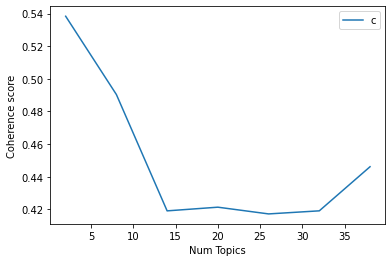

In [19]:
# Show graph
limit=40; start=2; step=6;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [20]:
# Print the coherence scores
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Num Topics = 2  has Coherence Value of 0.5383
Num Topics = 8  has Coherence Value of 0.4904
Num Topics = 14  has Coherence Value of 0.4191
Num Topics = 20  has Coherence Value of 0.4214
Num Topics = 26  has Coherence Value of 0.4173
Num Topics = 32  has Coherence Value of 0.4192
Num Topics = 38  has Coherence Value of 0.4462


In [21]:
# Select the model 1, because it has high coherence and print the topics
optimal_model = model_list[0]
model_topics = optimal_model.show_topics(formatted=False)
pprint(optimal_model.print_topics(num_words=10))

[(0,
  '0.041*"great" + 0.041*"battery" + 0.039*"work" + 0.037*"screen" + '
  '0.036*"good" + 0.035*"scratch" + 0.029*"phone" + 0.025*"love" + '
  '0.021*"purchase" + 0.020*"condition"'),
 (1,
  '0.141*"phone" + 0.023*"buy" + 0.016*"work" + 0.015*"time" + 0.015*"apple" + '
  '0.014*"product" + 0.014*"issue" + 0.013*"return" + 0.012*"back" + '
  '0.011*"seller"')]


**Summary of Topics:**
1. Topic 1: "great", "battery", "work", "screen", "good", "scratch", "phone", "love", "purchase", "condition" - **phone condition**
2. Topic 2: "phone", "buy", "work", "time", "apple", "product", "issue", "return", "back", "seller" - **services**


## (2) (10 points) Generate K topics by using LSA, the number of topics K should be decided by the coherence score, then summarize what are the topics. You may refer the code here:

https://www.datacamp.com/community/tutorials/discovering-hidden-topics-python

In [22]:
# Write your code here

# importing the required library
import os.path
from gensim import corpora
from gensim.models import LsiModel
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from gensim.models.coherencemodel import CoherenceModel
import matplotlib.pyplot as plt
import nltk; nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [23]:
# loading data
def load_data(path,file_name):
    documents_list = []
    titles=[]
    with open( os.path.join(path, file_name) ,"r") as fin:
        for line in fin.readlines():
            text = line.strip()
            documents_list.append(text)
    print("Total Number of Documents:",len(documents_list))
    titles.append( text[0:min(len(text),100)] )
    return documents_list,titles

In [24]:
# data preprocessing
def preprocess_data(doc_set):
    # initialize regex tokenizer
    tokenizer = RegexpTokenizer(r'\w+')
    # create English stop words list
    en_stop = set(stopwords.words('english'))
    # Create p_stemmer of class PorterStemmer
    p_stemmer = PorterStemmer()
    # list for tokenized documents in loop
    texts = []
    # loop through document list
    for i in doc_set:
        # clean and tokenize document string
        raw = i.lower()
        tokens = tokenizer.tokenize(raw)
        # remove stop words from tokens
        stopped_tokens = [i for i in tokens if not i in en_stop]
        # stem tokens
        stemmed_tokens = [p_stemmer.stem(i) for i in stopped_tokens]
        # add tokens to list
        texts.append(stemmed_tokens)
    return texts

In [25]:
# preparing clean data
def prepare_corpus(doc_clean):
    # Creating the term dictionary of our courpus, where every unique term is assigned an index. dictionary = corpora.Dictionary(doc_clean)
    dictionary = corpora.Dictionary(doc_clean)
    # Converting list of documents (corpus) into Document Term Matrix using dictionary prepared above.
    doc_term_matrix = [dictionary.doc2bow(doc) for doc in doc_clean]
    # generate LDA model
    return dictionary,doc_term_matrix

In [26]:
# creating an LSA model using Gensim
def create_gensim_lsa_model(doc_clean,number_of_topics,words):
    dictionary,doc_term_matrix=prepare_corpus(doc_clean)
    # generate LSA model
    lsamodel = LsiModel(doc_term_matrix, num_topics=number_of_topics, id2word = dictionary)  # train model
    print(lsamodel.print_topics(num_topics=number_of_topics, num_words=words))
    return lsamodel

In [27]:
# determining the number of topics
def compute_coherence_values(dictionary, doc_term_matrix, doc_clean, stop, start=2, step=3):
    coherence_values = []
    model_list = []
    for num_topics in range(start, stop, step):
        # generate LSA model
        model = LsiModel(doc_term_matrix, num_topics=number_of_topics, id2word = dictionary)  # train model
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=doc_clean, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())
    return model_list, coherence_values

In [42]:
# LSA Model
number_of_topics=7
words=10
document_list,titles=load_data("/content/","review_text.csv")
clean_text=preprocess_data(document_list)
model=create_gensim_lsa_model(clean_text,number_of_topics,words)

Total Number of Documents: 3384
[(0, '0.777*"phone" + 0.167*"work" + 0.159*"new" + 0.151*"iphon" + 0.137*"screen" + 0.126*"batteri" + 0.120*"came" + 0.108*"great" + 0.100*"one" + 0.100*"scratch"'), (1, '-0.409*"la" + -0.405*"que" + -0.368*"de" + -0.343*"el" + -0.283*"en" + -0.197*"lo" + -0.190*"con" + -0.162*"un" + -0.133*"es" + -0.130*"pero"'), (2, '-0.518*"phone" + 0.384*"iphon" + 0.279*"new" + 0.260*"batteri" + 0.212*"came" + 0.194*"screen" + 0.178*"great" + 0.172*"scratch" + 0.152*"good" + 0.148*"like"'), (3, '-0.610*"iphon" + 0.344*"came" + -0.275*"11" + 0.228*"scratch" + -0.204*"use" + 0.192*"batteri" + 0.134*"new" + 0.122*"screen" + -0.117*"camera" + -0.109*"product"'), (4, '0.521*"work" + -0.514*"screen" + 0.326*"great" + 0.275*"new" + -0.261*"scratch" + -0.193*"protector" + -0.126*"came" + 0.119*"brand" + 0.105*"love" + 0.089*"look"'), (5, '-0.614*"work" + 0.470*"new" + -0.275*"screen" + -0.207*"great" + 0.201*"brand" + 0.166*"like" + 0.157*"look" + 0.122*"phone" + -0.102*"goo

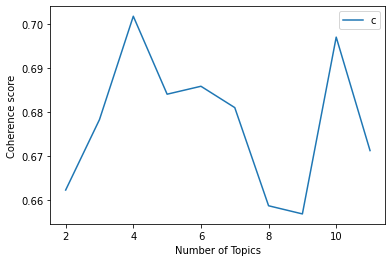

In [43]:
# plotting
def plot_graph(doc_clean,start, stop, step):
    dictionary,doc_term_matrix=prepare_corpus(doc_clean)
    model_list, coherence_values = compute_coherence_values(dictionary, doc_term_matrix,doc_clean,
                                                            stop, start, step)
    # Show graph
    x = range(start, stop, step)
    plt.plot(x, coherence_values)
    plt.xlabel("Number of Topics")
    plt.ylabel("Coherence score")
    plt.legend(("coherence_values"), loc='best')
    plt.show()

start,stop,step=2,12,1
plot_graph(clean_text,start,stop,step)

In [44]:
# number of topics taking as 4 as it has high coherence at 4 topics
number_of_topics=4
words=10
document_list,titles=load_data("/content/","review_text.csv")
clean_text=preprocess_data(document_list)
model=create_gensim_lsa_model(clean_text,number_of_topics,words)

Total Number of Documents: 3384
[(0, '0.777*"phone" + 0.167*"work" + 0.159*"new" + 0.151*"iphon" + 0.137*"screen" + 0.126*"batteri" + 0.120*"came" + 0.108*"great" + 0.100*"one" + 0.100*"scratch"'), (1, '0.409*"la" + 0.405*"que" + 0.368*"de" + 0.343*"el" + 0.283*"en" + 0.197*"lo" + 0.190*"con" + 0.162*"un" + 0.133*"es" + 0.130*"pero"'), (2, '0.518*"phone" + -0.384*"iphon" + -0.279*"new" + -0.260*"batteri" + -0.212*"came" + -0.194*"screen" + -0.178*"great" + -0.173*"scratch" + -0.152*"good" + -0.148*"like"'), (3, '-0.611*"iphon" + 0.344*"came" + -0.275*"11" + 0.228*"scratch" + -0.204*"use" + 0.192*"batteri" + 0.134*"new" + 0.123*"screen" + -0.116*"camera" + -0.109*"product"')]


**Summary of topics:**
1. Topic 1: "phone", "work", "new", "iphon", "screen", "batteri", "came", "great", "one", "scratch" - **phone condition**
2. Topic 2: "la", "que", "de", "el", "en", "lo", "con", "un", "es", "pero" - **language**
3. Topic 3: "phone", "iphon", "new", "batteri", "came", "screen", "great", "scratch", "good", "like" - **new phone**
4. Topic 4: "iphon", "came", "11", "scratch", "use", "batteri", "new", "screen", "camera", "product" - **hardware**


## (3) (10 points) Generate K topics by using  lda2vec, the number of topics K should be decided by the coherence score, then summarize what are the topics. You may refer the code here:

https://nbviewer.org/github/cemoody/lda2vec/blob/master/examples/twenty_newsgroups/lda2vec/lda2vec.ipynb

In [1]:
# Write your code here

!pip install pylda2vec

In [2]:
!pip install git+https://github.com/bmabey/pyLDAvis.git@master#egg=pyLDAvis

  Cloning https://github.com/bmabey/pyLDAvis.git (to revision master) to /tmp/pip-install-4w898_55/pyldavis_4d8686d6eb23450287b4fd2b3844c958
  Running command git clone -q https://github.com/bmabey/pyLDAvis.git /tmp/pip-install-4w898_55/pyldavis_4d8686d6eb23450287b4fd2b3844c958
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
    Preparing wheel metadata ... done
  Created wheel for pyLDAvis: filename=pyLDAvis-3.3.1-py2.py3-none-any.whl size=136898 sha256=f14086b77c30484cff0be377b56138290a0c7c68dd914af7bc1aabe6ed0874d4
  Stored in directory: /tmp/pip-ephem-wheel-cache-wv5__2y8/wheels/4d/ea/f8/01b5579f3fc1d71bf5177ff04fac5666300d32dba48afe48a1
Successfully built pyLDAvis


In [3]:
import pyLDAvis
pyLDAvis.enable_notebook()

/usr/local/lib/python3.7/dist-packages/past/types/oldstr.py:5: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import Iterable
/usr/local/lib/python3.7/dist-packages/past/builtins/misc.py:4: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import Mapping
/usr/local/lib/python3.7/dist-packages/scipy/fft/__init__.py:97: DeprecationWarning: The module numpy.dual is deprecated.  Instead of using dual, use the functions directly from numpy or scipy.
  from numpy.dual import register_func
/usr/local/lib/python3.7/dist-packages/scipy/sparse/sputils.py:17: DeprecationWarning: `np.typeDict` is a deprecated alias for `np.sctypeDict`.
  supported_dtypes = [np.typeDict[x] for x in supported_dtypes]
/usr/local/lib/python3.7/dist-packa

In [4]:
!pip install chainer

     |████████████████████████████████| 1.0 MB 5.5 MB/s 
  Created wheel for chainer: filename=chainer-7.8.1-py3-none-any.whl size=967740 sha256=dcea907d1d7c1195375956978223fb97c8a0c7a89d029deee3caa3ae68297aa6
  Stored in directory: /root/.cache/pip/wheels/c8/6a/6f/fd563166cc597e5206e375ea074ea836e5db5dd58421215672
Successfully built chainer


In [5]:
import spacy.cli
spacy.cli.download("en_core_web_md")

✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_md')


In [6]:
!pip install jellyfish

     |████████████████████████████████| 132 kB 5.5 MB/s 
  Created wheel for jellyfish: filename=jellyfish-0.9.0-cp37-cp37m-linux_x86_64.whl size=73960 sha256=f50b1ef49e114dbca91a4fa531b0bc70a1de079c1ffda623c630580345c4b8cd
  Stored in directory: /root/.cache/pip/wheels/fe/99/4e/646ce766df0d070b0ef04db27aa11543e2767fda3075aec31b
Successfully built jellyfish


In [7]:
from lda2vec import preprocess, Corpus
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

try:
    import seaborn
except:
    pass

/usr/local/lib/python3.7/dist-packages/scipy/io/matlab/mio5.py:98: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  from .mio5_utils import VarReader5
/usr/local/lib/python3.7/dist-packages/chainer/_environment_check.py:75: UserWarning: 
--------------------------------------------------------------------------------
CuPy (cupy-cuda111) version 9.4.0 may not be compatible with this version of Chainer.
Please consider installing the supported version by running:
  $ pip install 'cupy-cuda111>=7.7.0,<8.0.0'

See the following page for more details:
  https://docs.cupy.dev/en/latest/install.html
------------------------------------------------------------------------------

## (4) (10 points) Generate K topics by using BERTopic, the number of topics K should be decided by the coherence score, then summarize what are the topics. You may refer the code here: 

https://colab.research.google.com/drive/1FieRA9fLdkQEGDIMYl0I3MCjSUKVF8C-?usp=sharing

In [1]:
# Write your code here

%%capture
!pip install bertopic

In [4]:
# loading data
import pandas as pd
df = pd.read_csv('review_text.csv')
# Removing Punctuations and Noise
df['data1'] = df['Review'].str.replace('[^\w\s]',"")
df['data'] = df['data1'].str.replace("[^a-zA-Z#]", " ")

# converting the data to list
data = df.data.values.tolist()

#converting all list elements to strings
dataf = []
for ele in data:
  dataf.append(str(ele))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: FutureWarning: The default value of regex will change from True to False in a future version.
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: FutureWarning: The default value of regex will change from True to False in a future version.
  


In [5]:
from bertopic import BERTopic

topic_model = BERTopic(language="english", calculate_probabilities=True, verbose=True)
topics, probs = topic_model.fit_transform(dataf)

Downloading:   0%|          | 0.00/1.18k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/10.2k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/612 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/116 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/39.3k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/349 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/350 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/13.2k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/190 [00:00<?, ?B/s]

Batches:   0%|          | 0/96 [00:00<?, ?it/s]

2022-04-03 22:00:36,721 - BERTopic - Transformed documents to Embeddings
/usr/local/lib/python3.7/dist-packages/numba/np/ufunc/parallel.py:363: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 9107. The TBB threading layer is disabled.
  warnings.warn(problem)
2022-04-03 22:01:02,917 - BERTopic - Reduced dimensionality with UMAP
2022-04-03 22:01:03,663 - BERTopic - Clustered UMAP embeddings with HDBSCAN


In [7]:
freq = topic_model.get_topic_info(); freq.head(5)

,Topic,Count,Name
0,-1,1257,-1_the_phone_and_it
1,0,107,0_tel_fono_el_la
2,1,91,1_bater_de_la_con
3,2,80,2_came_protector_charger_box
4,3,76,3_unlocked_locked_to_not


In [8]:
topic_model.get_topic(0)  # Selecting the most frequent topic

[('tel', 0.06906663119804105),
 ('fono', 0.06837596488606064),
 ('el', 0.06026550708448033),
 ('la', 0.046866212991719045),
 ('que', 0.042880032523693185),
 ('en', 0.03997291909887385),
 ('con', 0.03619504149405275),
 ('de', 0.03472977267542498),
 ('un', 0.032013200704264916),
 ('se', 0.02984858313100818)]

In [9]:
topic_model.visualize_topics()

In [10]:
topic_model.visualize_distribution(probs[200], min_probability=0.015)

In [11]:
topic_model.visualize_hierarchy(top_n_topics=50)

In [12]:
topic_model.visualize_barchart(top_n_topics=5)

In [13]:
topic_model.visualize_heatmap(n_clusters=4, width=1000, height=1000)

In [14]:
topic_model.visualize_term_rank()

**Summary of Topics:**
1. Topic 1: "tel", "fono", "el", "la", "que" - **phone**
2. Topic 2: "bater", "de", "la", "con", "en" - **good**
3. Topic 3: "came", "protector", "charger", "box", "with" - **accessories**
4. Topic 4: "unlocked", "locked", "to", "not", "phone" - **unlocked phone**
5. Topic 5: "que", "de", "el", "la", "en" - **language**


## (5) (10 extra points) Compare the results generated by the four topic modeling algorithms, which one is better? You should explain the reasons in details.

In [8]:
# Write your answer here (no code needed for this question)

All these topic modelling algorithms are very efficient when the data input is huge. It also helps the model to learn and helps define the topics better. Here I used the all the Iphone 11 reviews from amazon as the input to the topic modeling algorithms.

In the first I used LDA topic modeling algorithm. The output was two topics with high coherence. Initally, I selected the 20 topics and later selected two because the coherence is high.

Secondly, I used LSA topic modeling. Initally, I selected 9 topics and later selected 4, as it has high coheerence.

Thrirdly, I used lda2vec topic modeling algorithm.

Finally, I used BERTopic topic modeling algorithm. The number of topics generated is four. As the coherence is high at four topics.

Out of all the models, in this case I feel LDA topic modeling algorithm is more accurate with high coherence. Because out of all the topics generated, the topics generated my LDA are more relevant and accurate to the dataset I used.